# Построение модели для предсказания оттока клиентов

## Задача
Заказчик: оператор связи «Ниединогоразрыва.ком» <br>
Дано: данные о клиентах и оказываемых услугах <br>
Задача: построить модель, предсказывающую отток клиентов компании, чтобы компания смогла попробовать удержать клиентов с помощью персональных предложений. <br><br>
Описание услуг:

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Исследовательский анализ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install phik -q
import phik
sns.set_theme(style="whitegrid")
from sklearn.compose import ColumnTransformer
!pip install catboost -q
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
!pip install shap -q
import shap
from sklearn.metrics import confusion_matrix
!pip install mlxtend  -q
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.patches as mpatches
from sklearn.dummy import DummyClassifier
RANDOM = 220523

In [ ]:
contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv',
                       index_col='customerID')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv',
                       index_col='customerID')
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv',
                       index_col='customerID')
phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv',
                    index_col='customerID')

In [ ]:
def df_explore(df):
    display(df.head(10))
    print(df.info())
    display(df.describe())
    print('Дубликатов в файле:', df.duplicated().sum())
    print('Из них с уникальными индексами:', df[df.duplicated()].index.nunique())


In [ ]:
df_explore(contract)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
None


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Дубликатов в файле: 37
Из них с уникальными индексами: 37


In [ ]:
df_explore(internet)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
None


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


Дубликатов в файле: 5389
Из них с уникальными индексами: 5389


In [ ]:
df_explore(personal)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Дубликатов в файле: 7027
Из них с уникальными индексами: 7027


In [ ]:
df_explore(phone)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB
None


,MultipleLines
count,6361
unique,2
top,No
freq,3390


Дубликатов в файле: 6359
Из них с уникальными индексами: 6359


Данные были выведены и проведен первичный осмотр. Дубликатов в файлах нет, т.к. у всех строк, найденных, как дубликаты, разные индексы, т.е. ID клиентов. В основном файле 7к строк, этого должно быть достаточно для обучения модели.<br>
Большинство полей представленно в некорректных типах, это нужно исправить до объединения таблиц. Также нужно выделить целевой признак и удалить ненужные колонки, добавить дополнительные признаки.

### Contract

In [ ]:
def convert_to_int(df, columns):
    if isinstance(columns, list):
        for col in columns:
            df[col] = (df[col] == 'Yes').astype(int)
    else:
        df[columns] = (df[columns] == 'Yes').astype(int)

def camel_to_snake(str):
    return ''.join(['_'+i.lower() if i.isupper() else i for i in str]).lstrip('_')

In [ ]:
UPLOAD_DATE = '2020-02-01'

#convert_to_int(contract, 'PaperlessBilling')
contract['BeginDate'] = contract['BeginDate'].apply(pd.to_datetime)
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = UPLOAD_DATE
contract['EndDate'] = contract['EndDate'].apply(pd.to_datetime)

# добавление новой колонки с количеством дней пользования сервисом до даты выгрузки базы
#contract['days_using'] = (pd.Timestamp(UPLOAD_DATE) - contract['BeginDate']).dt.days
contract['days_using'] = (contract['EndDate'] - contract['BeginDate']).dt.days
# добавление целевого признака
contract['is_quit'] = ((pd.Timestamp(UPLOAD_DATE) - contract['EndDate']).dt.days > 0).astype(int)


In [ ]:
#print(contract[contract['TotalCharges'] == ' ']['BeginDate'].unique())
#contract = contract.drop(contract[contract['TotalCharges'] == ' '].index)
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract.loc[
    contract['TotalCharges'] == ' ', 'MonthlyCharges']
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

In [ ]:
column_new = []
for column in contract.columns:
    column_new.append(camel_to_snake(column))

contract.columns = column_new

In [ ]:
display(contract.head())
print(contract.info())

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,days_using,is_quit
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,31,0
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1036,0
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,123,0
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,153,0


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   days_using         7043 non-null   int64         
 8   is_quit            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 550.2+ KB
None


Проработана таблица Contract. Поля приведены к нужным типам, добавлен признак количества дней, которые пользователь использует услуги компании и целевой признак. Удалены колонки начала и конца договора, т.к они вместе с новым добавленным признаком будут давать утеку целевого признака для модели. Также были проверены пустые ячейки в колонке TotalCharges, все они оказались для договоров, заключенных в день выгрузки базы, такие данные для нас неинформативны, они были удалены.
Для удобства работы названия колонок были приведены к привычному регистру.

### Internet

In [ ]:
columns = internet.columns.to_list()
columns.remove('InternetService')
#convert_to_int(internet, columns)

column_new = []
for column in internet.columns:
    column_new.append(camel_to_snake(column))

internet.columns = column_new

In [ ]:
display(internet.head())
print(internet.info())

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   object
 2   online_backup      5517 non-null   object
 3   device_protection  5517 non-null   object
 4   tech_support       5517 non-null   object
 5   streaming_t_v      5517 non-null   object
 6   streaming_movies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB
None


Таблица Internet обработана, признаки заменены на числовые.

### Personal

In [ ]:
personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv', index_col='customerID')

columns = ['Partner','Dependents']
#convert_to_int(personal, columns)
personal['gender'] = (personal['gender'] == 'Male').astype(int)

column_new = []
for column in personal.columns:
    column_new.append(camel_to_snake(column))

personal.columns = column_new

In [ ]:
display(personal.head())
print(personal.info())

,gender,senior_citizen,partner,dependents
customerID,,,,
7590-VHVEG,0,0,Yes,No
5575-GNVDE,1,0,No,No
3668-QPYBK,1,0,No,No
7795-CFOCW,1,0,No,No
9237-HQITU,0,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   int64 
 1   senior_citizen  7043 non-null   int64 
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: int64(2), object(2)
memory usage: 275.1+ KB
None


Таблица Personal переработана и приведена к стандартному виду.

### Phone

In [ ]:
#convert_to_int(phone, 'MultipleLines')
phone['has_phone'] = 'Yes'


column_new = []
for column in phone.columns:
    column_new.append(camel_to_snake(column))

phone.columns = column_new

In [ ]:
display(phone.head())
print(phone.info())

,multiple_lines,has_phone
customerID,,
5575-GNVDE,No,Yes
3668-QPYBK,No,Yes
9237-HQITU,No,Yes
9305-CDSKC,Yes,Yes
1452-KIOVK,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   multiple_lines  6361 non-null   object
 1   has_phone       6361 non-null   object
dtypes: object(2)
memory usage: 149.1+ KB
None


Для таблицы Phone было добавлено поле с индикатором, что человек использует услуги телефонии, т.к. в данной таблице строк меньше, чем в таблице со списком контрактов и это будет необходимо для корректного объединения таблиц и распределения признаков.

### Исследование данных

In [ ]:
data = contract.join(personal, how='left').join(internet, how='left').join(phone, how='left')
data = data.drop(['begin_date', 'end_date'], axis=1)

In [ ]:
data['internet_service'] = data['internet_service'].fillna('No internet')
#data = data.fillna(0)
data = data.fillna('No')
#columns = ['online_security', 'online_backup', 'device_protection',
#           'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines', 'has_phone']

#for col in columns:
#    data[col] = data[col].astype(int)
display(data.head())
print(data.info())

,type,paperless_billing,payment_method,monthly_charges,total_charges,days_using,is_quit,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,has_phone
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,31,0,0,0,Yes,No,DSL,No,Yes,No,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,1036,0,1,0,No,No,DSL,Yes,No,Yes,No,No,No,No,Yes
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,123,0,1,0,No,No,DSL,Yes,Yes,No,No,No,No,No,Yes
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,1371,0,1,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,153,0,0,0,No,No,Fiber optic,No,No,No,No,No,No,No,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   days_using         7043 non-null   int64  
 6   is_quit            7043 non-null   int64  
 7   gender             7043 non-null   int64  
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_t_v 

Провели объединение всех таблиц в один датасет. Пропуски для тех, у кого нет договора по использованию интернета заполнили значением no internet, остальные пропуски заполнены нулями и будут обозначать, что человек данными услугами не пользуется.

In [ ]:
print('Отношение количества ушедших клиентов к оставшимся:',
      round(data[data['is_quit'] == 1].shape[0] / data[data['is_quit'] == 0].shape[0], 1))

Отношение количества ушедших клиентов к оставшимся: 0.2


В данных наблюдается дисбаланс классов в соотношении 4:1, это нужно будет учитывать при построении модели. <br>

Сейчас можем посмотреть, есть ли какие-то типичные признаки для тех, кто уже разорвал контракт, которые помогут вычислить тех, кто может сдеать это в ближайшее время.

In [ ]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

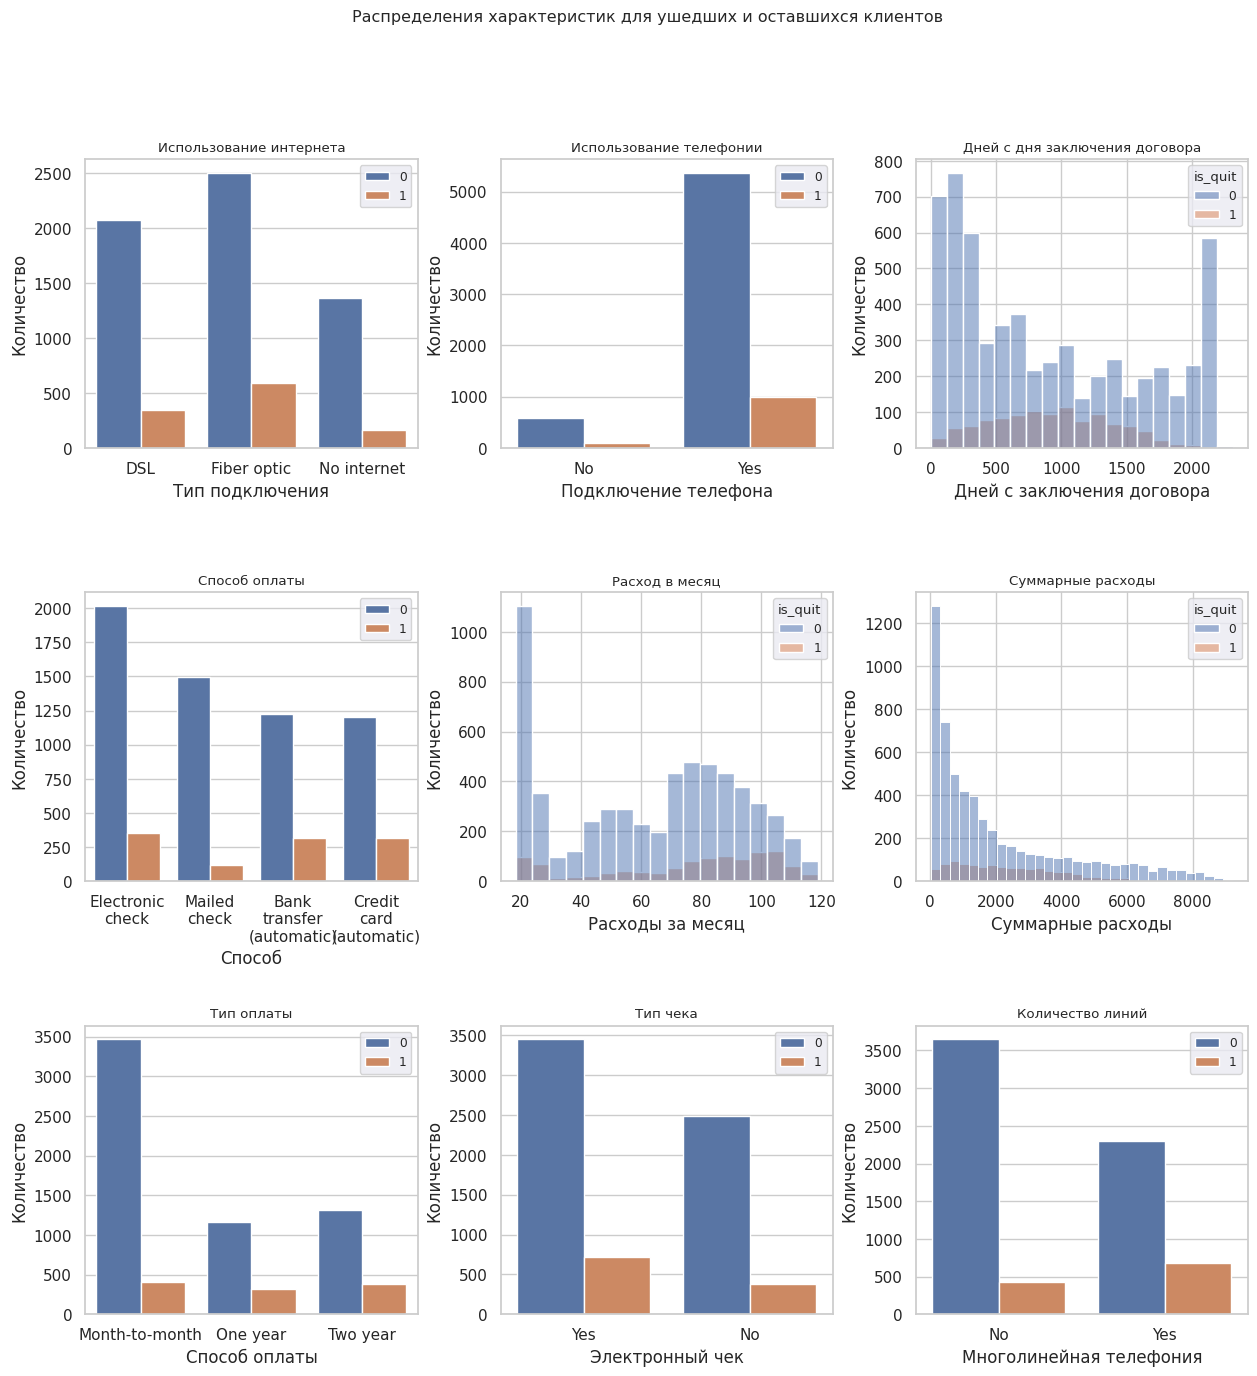

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))
fig.subplots_adjust(hspace=0.5, wspace=0.25)
sns.set(font_scale=0.8)
fig.suptitle('Распределения характеристик для ушедших и оставшихся клиентов')
axes[0, 0].set_title('Использование интернета')
sns.countplot(ax=axes[0,0], hue='is_quit', x='internet_service', data=data);
axes[0, 0].set(xlabel="Тип подключения",ylabel="Количество")
axes[0, 0].legend()

axes[0, 1].set_title('Использование телефонии')
sns.countplot(ax=axes[0, 1], hue='is_quit', x='has_phone', data=data);
axes[0, 1].set(xlabel="Подключение телефона",ylabel="Количество")
axes[0, 1].legend()

axes[0, 2].set_title('Дней с дня заключения договора')
sns.histplot(ax=axes[0, 2], hue='is_quit', x='days_using', data=data);
axes[0, 2].set(xlabel="Дней с заключения договора",ylabel="Количество")

axes[1, 0].set_title('Способ оплаты')
sns.countplot(ax=axes[1, 0], hue='is_quit', x='payment_method', data=data);
axes[1, 0].set(xlabel="Способ",ylabel="Количество")
axes[1, 0].legend()

axes[1, 1].set_title('Расход в месяц')
sns.histplot(ax=axes[1, 1], hue='is_quit', x='monthly_charges', data=data);
axes[1, 1].set(xlabel="Расходы за месяц",ylabel="Количество")

axes[1, 2].set_title('Суммарные расходы')
sns.histplot(ax=axes[1, 2], hue='is_quit', x='total_charges', data=data);
axes[1, 2].set(xlabel="Суммарные расходы",ylabel="Количество")

axes[2, 0].set_title('Тип оплаты')
sns.countplot(ax=axes[2, 0], hue='is_quit', x='type', data=data);
axes[2, 0].set(xlabel="Способ оплаты",ylabel="Количество")
axes[2, 0].legend()

axes[2, 1].set_title('Тип чека')
sns.countplot(ax=axes[2, 1], hue='is_quit', x='paperless_billing', data=data);
axes[2, 1].set(xlabel="Электронный чек",ylabel="Количество")
axes[2, 1].legend()

axes[2, 2].set_title('Количество линий')
sns.countplot(ax=axes[2, 2], hue='is_quit', x='multiple_lines', data=data);
axes[2, 2].set(xlabel="Многолинейная телефония",ylabel="Количество")
axes[2, 2].legend()

wrap_labels(axes[1,0], 10)

plt.show()

На основе полученных графиков можно попытаться сделать типичный портрет пользователя, который перестает пользоваться услугами компании. <br><br>
Больше всего уходит пользователей, которые уже 2-4года являются клиентами этой компании. Возможно для них действуют старые тарифы или же они ожидают более персонализированного отношения к таким лояльным клиентам. Также из всех пользователей интернета большего всего уходят польователей оптического подключения. Это может быть связано с высокой ценой оптоволоконного подключения или же недостаточному качеству. В планах расходов на связь, больше уходит людей из тех, у кого достаточно высокие месячные расходы, возможно люди замечают излишне высокие платежи и разрывают контракты. Стоит обратить внимание на то, чтобы помогать пользователям отключить ненужные им услуги. Если рассматривать способы оплаты, то чаще всего рассторгают договоры с автоматической оплатой и долгосрочными договорами. Возможно, это забытые контракты, которыми уже не пользовались.

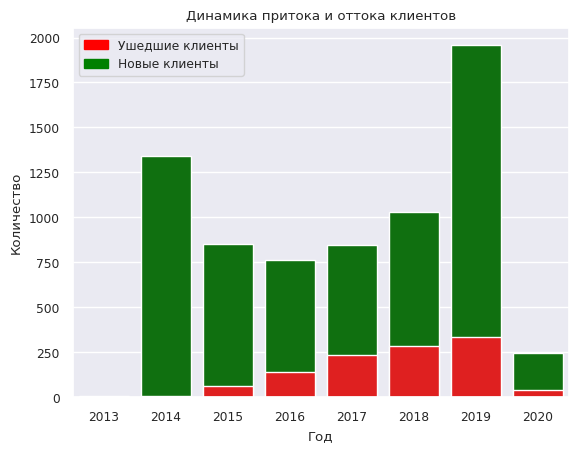

In [ ]:
new_users = contract.groupby(contract['begin_date'].dt.year)['begin_date'].count()
left_users = contract.groupby(contract['end_date'].dt.year)['end_date'].count()
new = new_users.to_frame().join(left_users.to_frame(), how='left').fillna(0).astype(int)
new.loc[2020, 'end_date'] = contract.loc[contract['end_date'].dt.year == 2020, 'is_quit'].sum()
new.columns = ['new', 'left']
plt.title('Динамика притока и оттока клиентов')
sns.barplot(x=new.index, y=new['new'], color='green');
sns.barplot(x=new.index, y=new['left'], color='red');
plt.xlabel('Год')
plt.ylabel('Количество')
red_patch = mpatches.Patch(color='red', label='Ушедшие клиенты')
green_patch = mpatches.Patch(color='green', label='Новые клиенты')
plt.legend(handles=[red_patch, green_patch])
plt.show()

На графике отображена динамика прироста новых клиентов и ухода старых клиентов в каждый год работы компании. Данные за 2020 год можно пока не учитывать, т.к. это данные только за январь, но вцелом можно сказать, что до 2019 года компания привлекала и теряла равномерное количество клиентов, а вот в 2019 им удалось привлечь бОльшее количество людей. Значит, что тактика в последний год рабоыт компании была выбрана верная, останется немного ее подкорректировать с помощью подготавливаемой модели, дабы минимизировать отток клиентов.

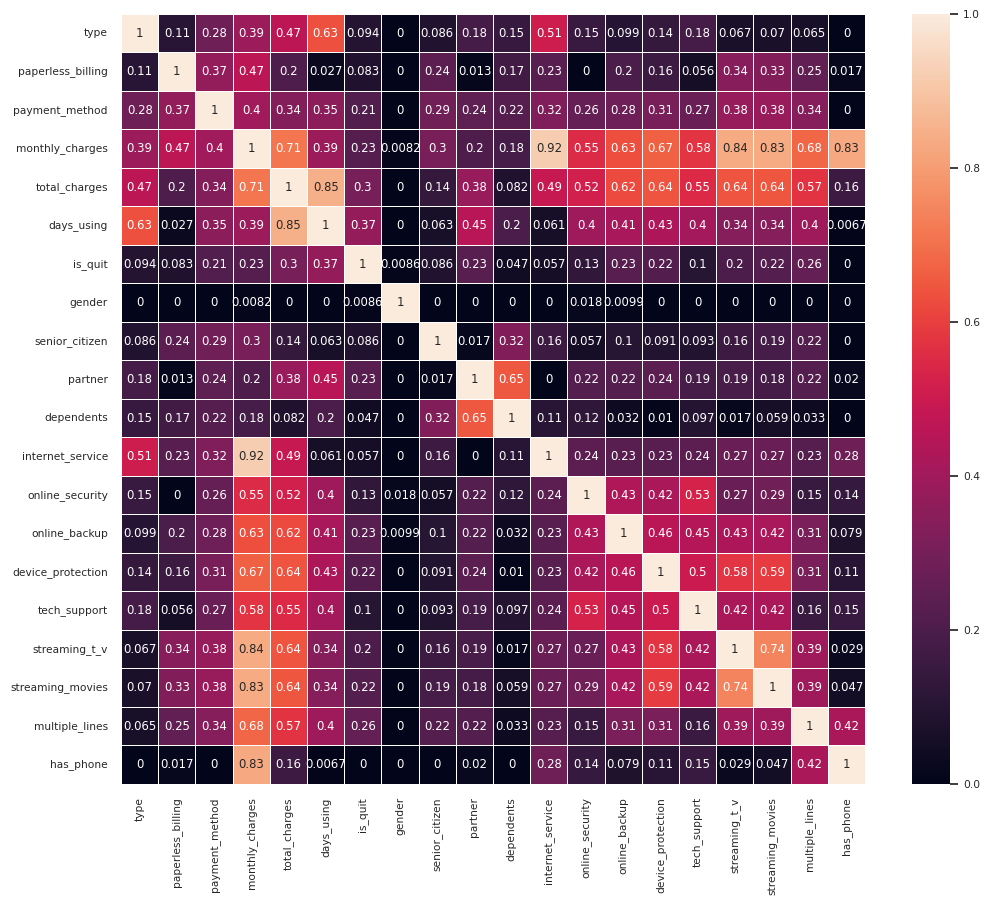

In [ ]:
corr = data.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'days_using'])
plt.figure(figsize=(12, 10))
sns.set(font_scale=0.7)
sns.heatmap(corr, annot=True, linewidth=.5);

Изучив матрицу корреляций (использовали Phik, т.к. нужно найти корреляции между категориальными переменными, а несколько числовых признаков, которые у нас есть, распределены ненормально и по этой причине коэффициент Пирсона для исследования не подходит), можно сказать, чо сильных зависимостей целевой переменной от признаков нет, есть ~0.5 значение в паре с длительностью контракта, что было обнаружено и ранее при построении графиков. <br><br>
Что касает мультиколлинеарности, она ожидаемо наблюдается между месячной платой и использованием дорогих услуг типа телефонной линии, стриминговых сервисов и интернета. Также прослеживается зависимость между суммарными тратами и количеством дней использования, что тоже логично. Можно убрать часть признаков из датасета, если будет использоваться модель, неустойчивая к мультиколлинеарности, пока все признаки можно оставить.

### Вывод
Закончен исследовательский анализ данных. Из 4-х файлов, предоставленных заказчиком, была собрана итоговая таблица, все данные приведены к корректным типам, добавлен целевой признак и создан новый признак (количество дней с подписания контракта), удалены ненужные признаки (даты начала и конца договора). С помощью графиков были выявлены некоторые закономерности в поведении типичного клиента, покинувшего компанию. С помощью корреляционной матрицы были получены пары признаков, между которыми можно наблюдать корелляционные связи, это будет учитываться при построении модели. Даные обработаны и готовы для следующего этапа разработки модели.

### Вопросы заказчику
1. Можно ли собрать дополнительные данные? Например возраст и город проживания. Возможно эти прзнаки улучшат работу модели.
2. Есть ли ограничения и требования к работе модели: время работы, используемые ресурсы?
3. Какие выделены сроки на данную задачу?

## Подбор моделей


In [ ]:
X = data.drop(['is_quit'], axis=1)
y = data['is_quit']

for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=RANDOM, stratify=y)

print(X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0])

display(X_train.head())

5282 1761 5282 1761


,type,paperless_billing,payment_method,monthly_charges,total_charges,days_using,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_t_v,streaming_movies,multiple_lines,has_phone
customerID,,,,,,,,,,,,,,,,,,,
7503-ZGUZJ,Month-to-month,Yes,Mailed check,84.65,169.30,62,1,0,No,No,Fiber optic,No,No,No,No,Yes,No,Yes,Yes
8331-ZXFOE,One year,Yes,Credit card (automatic),71.10,4165.04,1767,0,0,No,No,DSL,Yes,Yes,Yes,Yes,No,No,Yes,Yes
6723-CEGQI,Two year,No,Mailed check,45.25,2941.25,1979,0,0,No,Yes,DSL,No,Yes,No,Yes,Yes,No,No,No
4671-VJLCL,Two year,Yes,Credit card (automatic),79.85,5030.55,1918,0,0,No,No,DSL,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes
0402-CQAJN,Month-to-month,Yes,Bank transfer (automatic),101.90,1994.18,577,0,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Yes


In [ ]:
categorical_features = X_train.select_dtypes(include='category').columns.to_list()
print(categorical_features)
num_features = X_train.select_dtypes(include='float64').columns.to_list()
num_features.append('days_using')
print(num_features)

['type', 'paperless_billing', 'payment_method', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'multiple_lines', 'has_phone']
['monthly_charges', 'total_charges', 'days_using']


Данные подготовлены для модели, сделана разбивка на выборки (обучающую и тестовую), учитывая дисбаланс классов. Созданы списки численных и категориальных признаков для использования в трансофрмере.

### LinearSVC

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_features),
        ("cat", OneHotEncoder(drop='first', handle_unknown='error'), categorical_features),
    ]
)


In [ ]:
%%time
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('lsvc', LinearSVC(max_iter = 1500, random_state=RANDOM)),
])
parameters = {'lsvc__C': np.linspace(1, 11, num = 3, endpoint = True)}

model_lsvc = GridSearchCV(pipeline, parameters, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
scores_lsvc  = model_lsvc.fit(X_train, y_train)
print('Лучшая ROC-AUC для LinearSVC', round(scores_lsvc.best_score_, 2))
print(scores_lsvc.best_params_)



Fitting 5 folds for each of 3 candidates, totalling 15 fits
Лучшая ROC-AUC для LinearSVC 0.76
{'lsvc__C': 6.0}
CPU times: user 1.06 s, sys: 15.3 ms, total: 1.08 s
Wall time: 12 s


Liblinear failed to converge, increase the number of iterations.


Перебор гиперпараметров для LinearSVC модели не дал нужный результат, пробуем другие модели.

### RandomForestClassifier

In [ ]:
%%time
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ('rfc', RandomForestClassifier(random_state=RANDOM)),
])
parameters = {
    "rfc__n_estimators": [500],
    "rfc__max_depth": [5, 10],
    "rfc__max_features": [*np.arange(0.5, 1.0, 0.2)],
}

model_rfc = GridSearchCV(pipeline, parameters, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
scores_rfc  = model_rfc.fit(X_train, y_train)
print('Лучшая ROC-AUC для RandomForestClassifier', round(scores_rfc.best_score_, 2))
print(scores_rfc.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits



10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/loc

Лучшая ROC-AUC для RandomForestClassifier 0.84
{'rfc__max_depth': 10, 'rfc__max_features': 0.5, 'rfc__n_estimators': 500}
CPU times: user 5.62 s, sys: 101 ms, total: 5.72 s
Wall time: 2min 2s


Модель случайного леса также не дала нужный результат и при этом достаточно долго обучается с подбором гиперпараметров.

### CatBoostClassifier

In [ ]:
#print(num_features)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_features)
    ]
)

#X_train[num_features] = preprocessor.fit_transform(X_train)
#display(X_train.head())

In [ ]:
%%time

catboost = CatBoostClassifier(loss_function='CrossEntropy'
                              ,cat_features=categorical_features,
                              random_state=RANDOM
                              )
parameters = {#'learning_rate': [0.01, 0.03],
              #'depth': [3, 5, 10, 12],
              #'l2_leaf_reg': [1, 25, 50],
              'iterations': [1150]}
model_cat = GridSearchCV(catboost, parameters, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
scores_cat  = model_cat.fit(X_train, y_train)
print('Лучшая ROC-AUC для CatBoostClassifier', round(scores_cat.best_score_, 2))
print(scores_cat.best_params_)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.6686070	total: 58.9ms	remaining: 1m 7s
1:	learn: 0.6444533	total: 70.3ms	remaining: 40.4s
2:	learn: 0.6244330	total: 80.3ms	remaining: 30.7s
3:	learn: 0.6067162	total: 91.6ms	remaining: 26.2s
4:	learn: 0.5900808	total: 98.8ms	remaining: 22.6s
5:	learn: 0.5721940	total: 110ms	remaining: 21s
6:	learn: 0.5570577	total: 118ms	remaining: 19.2s
7:	learn: 0.5413539	total: 128ms	remaining: 18.3s
8:	learn: 0.5275594	total: 138ms	remaining: 17.4s
9:	learn: 0.5170111	total: 144ms	remaining: 16.4s
10:	learn: 0.5081116	total: 150ms	remaining: 15.5s
11:	learn: 0.4973445	total: 161ms	remaining: 15.2s
12:	learn: 0.4881400	total: 169ms	remaining: 14.8s
13:	learn: 0.4766233	total: 179ms	remaining: 14.5s
14:	learn: 0.4671074	total: 189ms	remaining: 14.3s
15:	learn: 0.4577867	total: 199ms	remaining: 14.1s
16:	learn: 0.4527804	total: 203ms	remaining: 13.5s
17:	learn: 0.4476940	total: 208ms	remaining: 13.1s
18:	learn: 0.4395562	total: 21

Модель CatBoost показала хороший результат, достигнута метрика ROC-AUC 0.89 при обучении с кросс-валидацией. В итоговой тетради закомментировала большинство гиперпараметров для перебора, т.к. это существенно увеличивало время обучения модели, оставила только параметр с лучшим показателем. Также убрала масштабирование числовых признаков для CatBoost, т.к. это ухудшило значение целевой метрики.

In [ ]:
y_pred_cat = cross_val_predict(model_cat, X_train, y_train, cv=3, method="predict_proba")[:, 1]
y_pred_rfc = cross_val_predict(model_rfc, X_train, y_train, cv=3, method="predict_proba")[:, 1]
y_pred_lsvc = cross_val_predict(model_lsvc, X_train, y_train, cv=3, method="predict")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.6682926	total: 12.4ms	remaining: 14.3s
1:	learn: 0.6409108	total: 26.4ms	remaining: 15.1s
2:	learn: 0.6177682	total: 34.1ms	remaining: 13s
3:	learn: 0.5980612	total: 42.1ms	remaining: 12.1s
4:	learn: 0.5804382	total: 49.6ms	remaining: 11.4s
5:	learn: 0.5645894	total: 57.4ms	remaining: 10.9s
6:	learn: 0.5536051	total: 60.5ms	remaining: 9.88s
7:	learn: 0.5412150	total: 65.2ms	remaining: 9.31s
8:	learn: 0.5277908	total: 73.1ms	remaining: 9.27s
9:	learn: 0.5146574	total: 81ms	remaining: 9.24s
10:	learn: 0.5040312	total: 88.7ms	remaining: 9.18s
11:	learn: 0.4918753	total: 96.3ms	remaining: 9.13s
12:	learn: 0.4814012	total: 104ms	remaining: 9.07s
13:	learn: 0.4710746	total: 111ms	remaining: 9.04s
14:	learn: 0.4647753	total: 116ms	remaining: 8.76s
15:	learn: 0.4566106	total: 126ms	remaining: 8.93s
16:	learn: 0.4476549	total: 133ms	remaining: 8.89s
17:	learn: 0.4400710	total: 141ms	remaining: 8.84s
18:	learn: 0.4324934	tota


10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/loc

Fitting 5 folds for each of 8 candidates, totalling 40 fits



10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/loc

Fitting 5 folds for each of 8 candidates, totalling 40 fits



10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/loc

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Liblinear failed to converge, increase the number of iterations.


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


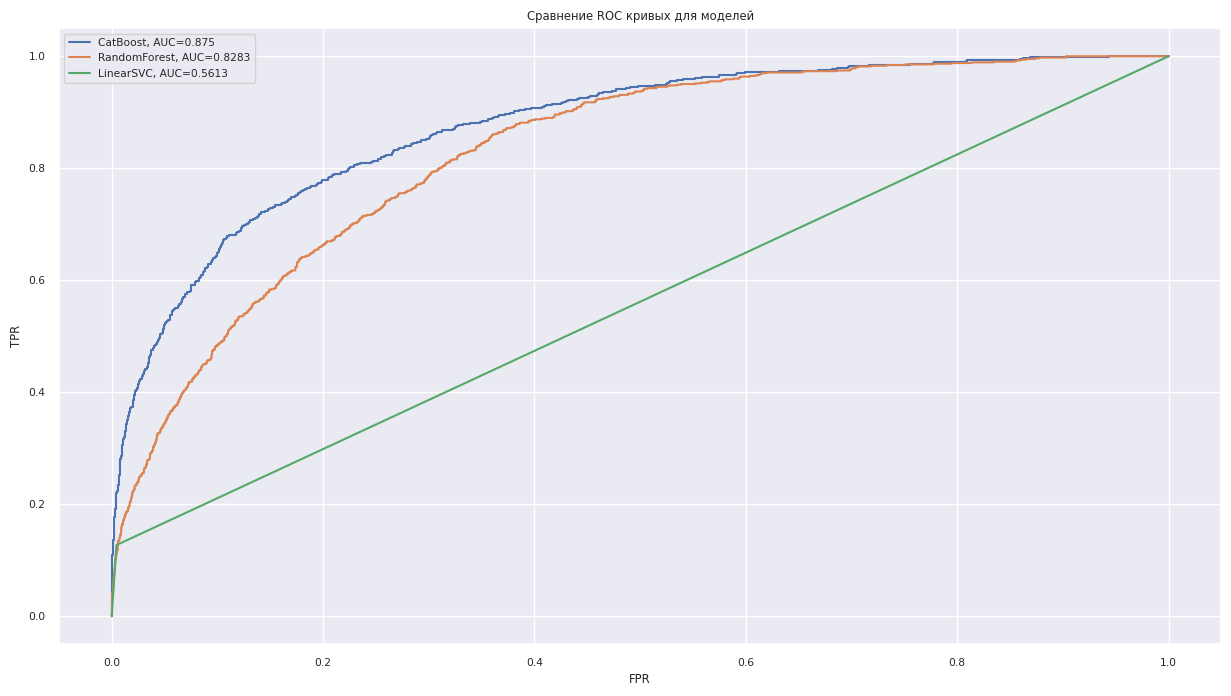

In [ ]:
plt.figure(figsize=(15, 8))
fpr, tpr, _ = roc_curve(y_train, y_pred_cat)
auc = round(roc_auc_score(y_train, y_pred_cat), 4)
plt.plot(fpr,tpr,label="CatBoost, AUC="+str(auc));
fpr, tpr, _ = roc_curve(y_train, y_pred_rfc)
auc = round(roc_auc_score(y_train, y_pred_rfc), 4)
plt.plot(fpr,tpr,label="RandomForest, AUC="+str(auc));
fpr, tpr, _ = roc_curve(y_train, y_pred_lsvc)
auc = round(roc_auc_score(y_train, y_pred_lsvc), 4)
plt.plot(fpr,tpr,label="LinearSVC, AUC="+str(auc));
plt.title('Сравнение ROC кривых для моделей')
plt.xlabel('FPR')
plt.ylabel('TPR')

#add legend
plt.legend();

Построив графики ROC- кривых для всех моделей, становится очевидно, что CatBoost действительно лучше при любом пороговом значении.

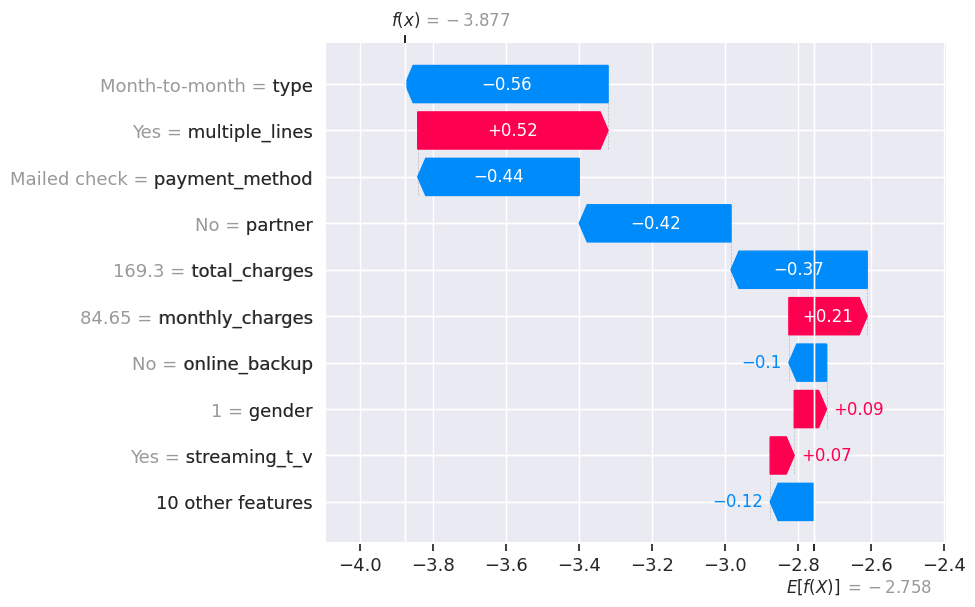

In [ ]:
explainer = shap.Explainer(model_cat.best_estimator_)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values[0])

In [ ]:
def global_shap_importance(model, X):
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

columns = global_shap_importance(model_cat.best_estimator_, X_train).head(10)['features'].to_list()
display(columns)

X_new = X.drop(columns=[col for col in X if col not in columns])

['days_using',
 'type',
 'total_charges',
 'multiple_lines',
 'partner',
 'payment_method',
 'monthly_charges',
 'online_backup',
 'device_protection',
 'streaming_movies']

С помощью SHAP, использующего теорию игр, выяснили вклад каждого признака в итоговую метрику, отобрали 10 наиболее значимых фич и попробуем переобучить модель только на этих данных.

In [ ]:
for c in X_new.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_new[c] = X_new[c].astype('category')

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size=.25, random_state=RANDOM, stratify=y)

print(X_train_new.shape[0], X_test_new.shape[0], y_train_new.shape[0], y_test_new.shape[0])

5282 1761 5282 1761


Новая выборка с отбранными 10 признаками разбита на обучающую и тестовую выборки.

In [ ]:
%%time
categorical_features = X_train_new.select_dtypes(include='category').columns.to_list()

num_features = X_train_new.select_dtypes(include='float64').columns.to_list()
num_features.append('days_using')

preprocessor_new = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_features)
    ]
)

#X_train_new[num_features] = preprocessor_new.fit_transform(X_train_new)


catboost_shap = CatBoostClassifier(eval_metric='AUC',
                              cat_features=categorical_features,
                                  random_state=RANDOM)
parameters = {#'learning_rate': [0.01, 0.05],
              #'depth': [3, 5, 7, 10],
              #'l2_leaf_reg': [1, 25],
              'iterations': [1000]}
model_cat_shap = GridSearchCV(catboost_shap, parameters, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
scores_cat_shap  = model_cat_shap.fit(X_train_new, y_train_new)
print('Лучшая ROC-AUC для CatBoostClassifier', round(scores_cat_shap.best_score_, 2))
print(scores_cat_shap.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.020969
0:	total: 8.55ms	remaining: 8.54s
1:	total: 17ms	remaining: 8.46s
2:	total: 20.6ms	remaining: 6.85s
3:	total: 28.7ms	remaining: 7.14s
4:	total: 36.4ms	remaining: 7.25s
5:	total: 42.3ms	remaining: 7.01s
6:	total: 49.2ms	remaining: 6.98s
7:	total: 56.9ms	remaining: 7.05s
8:	total: 64.6ms	remaining: 7.11s
9:	total: 70.5ms	remaining: 6.98s
10:	total: 78.4ms	remaining: 7.05s
11:	total: 86.6ms	remaining: 7.13s
12:	total: 94.9ms	remaining: 7.2s
13:	total: 103ms	remaining: 7.25s
14:	total: 111ms	remaining: 7.28s
15:	total: 119ms	remaining: 7.34s
16:	total: 129ms	remaining: 7.43s
17:	total: 136ms	remaining: 7.42s
18:	total: 143ms	remaining: 7.39s
19:	total: 147ms	remaining: 7.2s
20:	total: 154ms	remaining: 7.18s
21:	total: 162ms	remaining: 7.2s
22:	total: 171ms	remaining: 7.25s
23:	total: 185ms	remaining: 7.51s
24:	total: 198ms	remaining: 7.71s
25:	total: 204ms	remaining: 7.65s
26:	total: 211ms	remaining: 7

Модель CatBoost обучена на урезанном датасете, но показала узудшение результата, возможно из-за слишком малого количества признаков. Попробуем протестировать обе модели на етстовой выборке.

In [ ]:
#X_test_new[num_features] = preprocessor_new.transform(X_test_new)
#X_test[num_features] = preprocessor.transform(X_test)

predictions = model_cat.predict_proba(X_test)[:, 1]
predictions_acc = model_cat.predict(X_test)

print('Лучшая ROC-AUC для CatBoostClassifier', round(roc_auc_score(y_test, predictions), 2))
print('Лучшая Accuracy для CatBoostClassifier', round(accuracy_score(predictions_acc, y_test), 2))

predictions_shap = model_cat_shap.predict_proba(X_test_new)[:, 1]
predictions_shap_acc = model_cat_shap.predict(X_test_new)

print('Лучшая ROC-AUC для CatBoostClassifier_shap', round(roc_auc_score(y_test_new, predictions_shap), 2))
print('Лучшая Accuracy для CatBoostClassifier_shap', round(accuracy_score(predictions_shap_acc, y_test_new), 2))

Лучшая ROC-AUC для CatBoostClassifier 0.91
Лучшая Accuracy для CatBoostClassifier 0.9
Лучшая ROC-AUC для CatBoostClassifier_shap 0.9
Лучшая Accuracy для CatBoostClassifier_shap 0.9


In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_test, y_test)
predictions_dummy = dummy_clf.predict_proba(X_test)[:,1]
print('Лучшая ROC-AUC для CatBoostClassifier', round(roc_auc_score(y_test, predictions_dummy), 2))

Лучшая ROC-AUC для CatBoostClassifier 0.5


Обе модели прошли требуемое пороговое значение метрики, но при этом модель, обученная без удаления несущественных признаков, показала лучший результат, ее и будем рекомендовать заказчику. Время обучения модели составило 13 секунд, вполне хороший результат, тем более заказчик не устанавливал ограничения по времени обучения, это станет приятным бонусом.
Для уверенности провели сравнение моделей с baseline моделью, которая ожидаемо показала намного худший резульат.

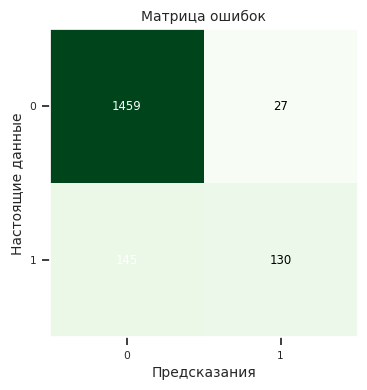

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions_acc)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(4, 4), cmap=plt.cm.Greens)
plt.xlabel('Предсказания', fontsize=10)
plt.ylabel('Настоящие данные', fontsize=10)
plt.title('Матрица ошибок', fontsize=10)
plt.show()

Построили матрицу ошибок для выбранной модели, модель терет достаточно много потенциально готовых к уходу клиентов, это можно изменить, меняя пороговое значение для модели.

Лучшая ROC-AUC для CatBoostClassifier 0.9
Лучшая Accuracy для CatBoostClassifier 0.9


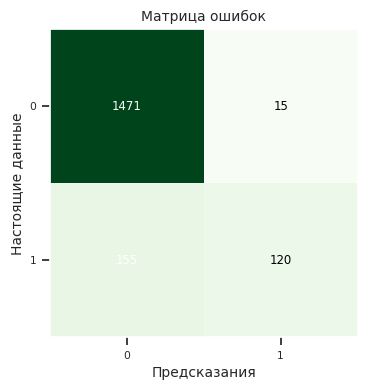

In [ ]:
model_cat.best_estimator_.set_probability_threshold(0.56)
predictions = model_cat.predict(X_test)

print('Лучшая ROC-AUC для CatBoostClassifier', round(roc_auc_score(predictions, y_test), 2))
print('Лучшая Accuracy для CatBoostClassifier', round(accuracy_score(predictions, y_test), 2))

conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(4, 4), cmap=plt.cm.Greens)
plt.xlabel('Предсказания', fontsize=10)
plt.ylabel('Настоящие данные', fontsize=10)
plt.title('Матрица ошибок', fontsize=10)
plt.show()

При увеичении порога мы получаем улучшенную метрику ROC-AUC, но при этом модель еще больше клиентов, ушедших из компании, не распознала, хотя это основная задача, поставленная клиентом.

Лучшая ROC-AUC для CatBoostClassifier 0.85
Лучшая Accuracy для CatBoostClassifier 0.9


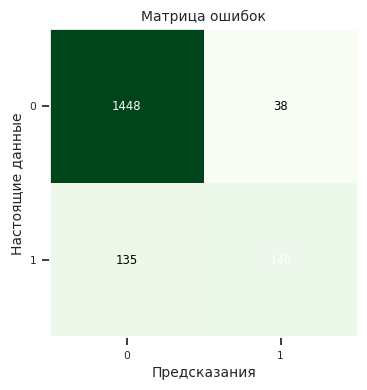

In [ ]:
model_cat.best_estimator_.set_probability_threshold(0.46)
predictions = model_cat.predict(X_test)

print('Лучшая ROC-AUC для CatBoostClassifier', round(roc_auc_score(predictions, y_test), 2))
print('Лучшая Accuracy для CatBoostClassifier', round(accuracy_score(predictions, y_test), 2))

conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(4, 4), cmap=plt.cm.Greens)
plt.xlabel('Предсказания', fontsize=10)
plt.ylabel('Настоящие данные', fontsize=10)
plt.title('Матрица ошибок', fontsize=10)
plt.show()

При уменьшении порога пострадала метрика ROC-AUC, но зато модель сделала меньше FalseNegative предсказаний, что поможет спасти больше клиентов. Но так же больше ошиблась с FalsePositive оценками, что в итоге увеличило общее количество клиентов, помеченных как готовых отказаться от услуг компании. Предлагаю оставить на рассмотрение менеджера этот вопрос, т.к. нам недостаточно данных для определения экономической целессобразности проведения мероприятий по удержанию клиентов. Т.е. мы не можем сказать, чтобудет выгоднее, упустить нескольких клиентов, но потратиться на промокомпании для меньшего в сумме количества клиентов. Или же наоборот, потратить деньги на промокомпании для бОльшего количества клиентов, хотя часть из них на самом деле не собиралась покидать компанию.

### Вывод
Были обучены 3 разных типа моделей, линейная модель и модель случайного леса не показали приемлемых результатов, а вот модель, обучающаяся методом градиентного бустинга, показала хороший результат. С помощью варьирования порога удалось добиться значения AUC-ROC = 0.91 на тестовой выборке. Дополнительно были изучены признаки и их вклад в предсказания моделей, но попытка оставить только наиболее значимые из них не дала прироста целевой метрики, этот вариант был отброшен.
Далее были изучены матрицы ошибок, чтобы детальнее увидеть конкретные цифры и с помощью варьирования порогового значения для модели были получены следующие результаты: при повышении порога растет целевая метрика, но при это бОльшее количество ушедших клиентов не распознается моделью. При понижении порога метрика падает, но модель распознает больше ушедших клиентов, хотя и чаще ошибаеся при указании класса 1 для лояльных клиентов. Эти выводы подробно расписаны выше и на выбор менеджменту компании будет предоставлена одна модель CatBoost, но с возможностью варьирования порогового значения в зависимости от решения менеджмента компании.

## Общий вывод
Заказчиком была поставлена задача по построению модели для предсказания оттока клиентов компании. Предоставлены были исторические данные о клиентах и используемых ими услугах. <br>
Данные были обработаны, изучены, объединены в одну таблицу. Также были рассмотренны закономерности в данных, основные из них:
- Больше всего уходит пользователей, которые уже 2-4года являются клиентами этой компании. Возможно для них действуют старые тарифы или же они ожидают более персонализированного отношения к таким лояльным клиентам.
- Также из всех пользователей интернета большего всего уходят польователей оптического подключения. Это может быть связано с высокой ценой оптоволоконного подключения или же недостаточному качеству.
- В планах расходов на связь, больше уходит людей из тех, у кого достаточно высокие месячные расходы, возможно люди замечают излишне высокие платежи и разрывают контракты. Стоит обратить внимание на то, чтобы помогать пользователям отключить ненужные им услуги.
- Если рассматривать способы оплаты, то чаще всего рассторгают договоры с автоматической оплатой и долгосрочными договорами. Возможно, это забытые контракты, которыми уже не пользовались.

<br><br>
Были изучены общие показатели компании, пока динамика не критичная, новых клиентов в каждый год становится больше, чем ушедших, но в абсолютном значении ушедших клиентов много, так что заказчик вовремя обратился за созданием модели, которая поможет избежать оттока клиентов.
<br><br>
После проверки признаков на мультиколлинеарность и корелляции целевого признака с фичами была отмечена достаточная зависимость целевого признака от длительности контракта, что было отмечено и ранее. В плане мультиколлинеарности, были выделены связи дополнительных услуг с величиной оплаты, что вполне логично, но т.к. выбранная нами модель устойчива к мультиколлинеарности, то преждевременно удалять признаки не стали.
<br><br>
Были обучены 3 разных типа моделей, линейная модель и модель случайного леса не показали приемлемых результатов, а вот модель, обучающаяся методом градиентного бустинга, показала хороший результат. Лучший результат метрики AUC-ROC = 0.91 на тестовой выборке.  
<br><br>
Дополнительно были изучены признаки и их вклад в предсказания моделей, но попытка оставить только наиболее значимые из них не дала прироста целевой метрики, этот вариант был отброшен.
Далее были изучены матрицы ошибок, чтобы детальнее увидеть конкретные цифры и с помощью варьирования порогового значения для модели были получены следующие результаты: при повышении порога растет целевая метрика, но при это бОльшее количество ушедших клиентов не распознается моделью. При понижении порога метрика падает, но модель распознает больше ушедших клиентов, хотя и чаще ошибаеся при указании класса 1 для лояльных клиентов. Эти выводы подробно расписаны выше и на выбор менеджменту компании будет предоставлена одна модель CatBoost, но с возможностью варьирования порогового значения в зависимости от решения менеджмента компании.
<br><br>
Компании можно порекомендовать следующее:
- Начать собирать дополнительные данные о пользователях: возраст, город проживания, это может улучшить работу модели.
- Предоставить больше данных о том, какие маркетинговые ходы возможны для удержания клиентов, их стоимость. Это помогло бы более точно подобрать модель под конкретные запросы компании, т.к. экономическая целесообразность проведения кампаний по удержанию клиентов может потребовать подгона работы модели под конкретные нужды (изменени порогового значения, обоснованное в предыдущем разделе).
- Обратить внимание на выявленные закономерности и учесть их в стратегии компании.

## Отчет
Поставленная задача моделирования была полностью выполнена по пожеланиям заказчика. Предоставленные данные были разбиты на 4 файла с разным количеством строк, это поставило первую задачу по подготовке данных и правильному их объединению в одну таблицу с корректными заполнениями пропусков для избежания утери и искажения данных. Создавая новые признаки идобавляя новые категории этого удалось избежать. Далее, на этапе подготовки в данных был создан новый признак с количеством дней, которые пользователь пребывает в компании. Он нужен для тго, чтобы отследить лояльность пользователя и удалить из данных столбцы с прямыми датами начала и конца контракта, т.к. они будут являться утечкой информации при обучении модели и итоговая модель будет неспособна качественно работать с будущими датами. Сформированная итоговая таблица была изучена на предмет сильных корреляций между признаками и целевым признаком, выведены некоторые закономерности, которые могут помочь менеджменту компании отследить тенденции ухода клиентов и отработать методы по их устранению:
- Больше всего уходит пользователей, которые уже 2-4года являются клиентами этой компании. Возможно для них действуют старые тарифы или же они ожидают более персонализированного отношения к таким лояльным клиентам.
- Также из всех пользователей интернета большего всего уходят польователей оптического подключения. Это может быть связано с высокой ценой оптоволоконного подключения или же недостаточному качеству.
- В планах расходов на связь, больше уходит людей из тех, у кого достаточно высокие месячные расходы, возможно люди замечают излишне высокие платежи и разрывают контракты. Стоит обратить внимание на то, чтобы помогать пользователям отключить ненужные им услуги.
- Если рассматривать способы оплаты, то чаще всего рассторгают договоры с автоматической оплатой и долгосрочными договорами. Возможно, это забытые контракты, которыми уже не пользовались.

<br><br>
На следующем этапе данные были разбиты на обучающую и тестовую выборки, признаки определены как категориальные и числовые, подготовлены соотвествующие кодировщики: OneHotEncoder и MinMaxScaler, после чего были переданы в три исследуемые модели: LinearSVR, RandomForest и CatBoost. Во всех моделях обучение проводилось с кросс-валидацией, испльзуя Pipeline для кодирования выборок непосредственно перед передачей в модель для избежания утечки данных и переобучения. Для каждой модели проводился подбор гиперпараметров с максимизацией целевой метрики ROC-AUC. Для модели CatBoost также был проведен анализ важности признаков с помощью Shap, но выделение ключевых 8-10 признаков не улучшило качество модели и поэтому было решено оставить полный набор данных, учитывая, что обучение модели заняло всего 13 секунд В итоге лучшей оказалась модель CatBoost со своими дефолтовыми параметрами и количеством итераций 1000. На ней удалось достичь показателя ROC-AUC = 0.91 на тестовой выборке и точности 0.9.  
<br><br>
Дополнительно было изучено влияние порогового значения в модели на количественные показатели ошибок, что может помочь руководству компании определить, какой порог будет более экономически целесообразен в данной ситуации.
<br><br>
Дополнительные рекомендации для компании:
- Начать собирать дополнительные данные о пользователях: возраст, город проживания, это может улучшить работу модели.
- Предоставить больше данных о том, какие маркетинговые ходы возможны для удержания клиентов, их стоимость. Это помогло бы более точно подобрать модель под конкретные запросы компании, т.к. экономическая целесообразность проведения кампаний по удержанию клиентов может потребовать подгона работы модели под конкретные нужды (изменени порогового значения, обоснованное в предыдущем разделе).
- Обратить внимание на выявленные закономерности и учесть их в стратегии компании.